# Coding sections (Skip down to Results Section)

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display


### Transform CSV in programmable JSON

```python
scores: {
    "team_name": {
        "week_name": {
            "problem_name": {
                "person_name: {
                    "attempts": int
                    "top": int, 1 for yes 0 for no
                    "zone": int,  1 for yes 0 for no
                }
            }
        }
    }
}
```

In [13]:
person_scores = {
    "advanced": {},
    "intermediate": {},
    "recreational": {}
}


def read_person_weekly_scores(all_person_scores):
    weekly_scores = {}
    starting_positions = range(0, len(all_person_scores), 3)
    for week, i in enumerate(starting_positions):
        raw_scores = all_person_scores[i:i+3]
        weekly_scores[f"week-{len(starting_positions)-week}"] = {
            "tops": int(raw_scores[0].strip()),
            "zones": int(raw_scores[1].strip()),
            "attempts": int(raw_scores[2].strip()),
        }
    return weekly_scores


with open("BKBouldering League 2.0 - Overall Individual Scores.csv") as indi_scores_file:
    cat = "advanced"
    for line_num, line in enumerate(indi_scores_file.readlines()):
        if line_num < 3:
            continue
        if "intermediate" in line.lower():
            cat = "intermediate"
        elif "recreational" in line.lower():
            cat = "recreational"
        else:
            cells = line.split(",")
            if cells[0].strip() == "":
                continue
            name = cells[1]
            scores = cells[5:]
            person_scores[cat][name] = read_person_weekly_scores(scores)
            if "zander" in name.lower():
                pprint(person_scores[cat][name])

{'week-1': {'attempts': 0, 'tops': 0, 'zones': 0},
 'week-2': {'attempts': 13, 'tops': 8, 'zones': 9}}


In [16]:
aggregate_scores = {}
worst_weeks = {}
for cat in person_scores.keys():
    aggregate_scores[cat] = {}
    worst_weeks[cat] = {}
    for person in person_scores[cat].keys():
        aggregate_scores[cat][person] = {
            "overall": {},
            "adjusted": {}
        }
        weekly_scores = list(person_scores[cat][person].values())
        aggregate_scores[cat][person]["overall"] = {
            "tops": sum(map(lambda s: s["tops"], weekly_scores)),
            "zones": sum(map(lambda s: s["zones"], weekly_scores)),
            "attempts": sum(map(lambda s: s["attempts"], weekly_scores))
        }
        sorted_weekly_scores = sorted(
            weekly_scores, 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts']) # sort by max zones, max tops, min atttemps
        )
        min_week = sorted_weekly_scores[-1]
        worst_weeks[cat][person] = min_week
        aggregate_scores[cat][person]["adjusted"] = {
            "tops": aggregate_scores[cat][person]["overall"]["tops"] - min_week["tops"],
            "zones": aggregate_scores[cat][person]["overall"]["zones"] - min_week["zones"],
            "attempts": aggregate_scores[cat][person]["overall"]["attempts"] - min_week["attempts"],
        }

In [4]:
def prepare_results(catgeory, score_type):
    scores = []
    for person in aggregate_scores[catgeory].keys():
        score = aggregate_scores[catgeory][person][score_type].copy()
        score["name"] = person
        score["worst_week"] = json.dumps(worst_weeks[catgeory][person])
        scores.append(score)

    scores_df = pd.DataFrame.from_dict(scores).set_index("name")

    # sorting
    scores_df["attempts"] = -scores_df["attempts"]
    scores_df = scores_df.sort_values(by=['tops', 'zones', 'attempts'], ascending=False)

    scores_df["attempts"] = -scores_df["attempts"]
    scores_df['rank'] = range(len(scores_df))
    scores_df['rank'] += 1 
    scores_df = scores_df.reindex(columns=['rank', 'tops', 'zones', 'attempts', 'worst_week'])
    return scores_df

def plot_results(ranked_dataframe, title, height=18):
    g = sns.catplot(
        data=ranked_dataframe.melt(ignore_index=False, var_name='cols', value_name='vals').reset_index(), 
        kind="bar",
        x="vals", 
        y="name", 
        hue="cols",
        height=height,
        aspect=1.5
    )
    g.set(title=title)
    g.set_axis_labels("Count", "Rankings")
    g.legend.set_title("Legend")

    # extract the matplotlib axes_subplot objects from the FacetGrid
    ax = g.facet_axis(0, 0)

    # iterate through the axes containers
    for c in ax.containers:
        labels = [f'{(v.get_width()):.0f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

In [23]:
def weekly_ranks(catgeory):
    # pivote the data to be by week
    weekly_person_scores = {}
    for person in person_scores[catgeory].keys():
        for week in person_scores[catgeory][person].keys():
            if week not in weekly_person_scores:
                weekly_person_scores[week] = []
            item =  person_scores[catgeory][person][week].copy()
            item["name"] = person
            weekly_person_scores[week].append(item)

    person_ranks={}
    for week in weekly_person_scores.keys():
        sorted_week_scores = sorted(
            weekly_person_scores[week], 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts'])
        )
        for rank, item in enumerate(sorted_week_scores):
            if item["name"] not in person_ranks:
                person_ranks[item["name"]] = []
            person_ranks[item["name"]].append(rank+1)
    return person_ranks


def plot_rank_progression(weekly_ranks, title):
    # let's figure out the starting and ending ranks first
    starting_ranks = list(map(lambda name: (f"{name}({weekly_ranks[name][0]})", weekly_ranks[name][0]), weekly_ranks.keys()))
    starting_tick_labels=[]
    starting_ticks=[]
    for rank in starting_ranks:
        starting_tick_labels.append(rank[0])
        starting_ticks.append(rank[1])
    ending_ranks = list(map(lambda name: (f"{name}({weekly_ranks[name][-1]})", weekly_ranks[name][-1]), weekly_ranks.keys()))
    ending_tick_labels=[]
    ending_ticks=[]
    for rank in ending_ranks:
        ending_tick_labels.append(rank[0])
        ending_ticks.append(rank[1])

    num_weeks = np.max(list(map(lambda x: len(x), weekly_ranks.values())))

    # now lets setup some basic labelling for readability
    fig, ax1 = plt.subplots(figsize=(num_weeks*2, len(weekly_ranks.keys())))

    plt.title(title)
    plt.grid(True, linestyle='--')
    
    ax2 = ax1.twinx()
    ax1.invert_yaxis()
    ax2.invert_yaxis()

    ax1.set_xlabel("Weeks")

    ax1.set_ylabel("Starting Rank")
    ax1.set_yticks(starting_ticks, labels=starting_tick_labels)
    ax2.set_ylabel("Ending Rank")
    ax2.set_yticks(ending_ticks, labels=ending_tick_labels)

    x_ticks = range(int(num_weeks))
    x_labels = list(map(lambda n: f"week-{n+1}", x_ticks))
    ax1.set_xticks(x_ticks, labels=x_labels)
    for person in weekly_ranks.keys():
        ax1.plot(weekly_ranks[person], marker="o", mfc="w", markersize=10)
        ax2.plot(weekly_ranks[person], marker="o", mfc="w", markersize=10)

In [24]:

def weekly_ranks_cummulative(catgeory):
    # pivote the data to be by week
    weekly_person_scores = {}
    for person in person_scores[catgeory].keys():
        score_so_far = {
            "tops": 0,
            "zones": 0,
            "attempts": 0,
        }
        for week in person_scores[catgeory][person].keys():
            if week not in weekly_person_scores:
                weekly_person_scores[week] = []
            score_so_far["tops"] += person_scores[catgeory][person][week]["tops"]
            score_so_far["zones"] += person_scores[catgeory][person][week]["zones"]
            score_so_far["attempts"] += person_scores[catgeory][person][week]["attempts"]
            item = {
                "name": person,
                "tops": score_so_far["tops"],
                "zones": score_so_far["tops"],
                "attempts": score_so_far["tops"],
            }
            if "zander" in person.lower():
                pprint(person_scores[catgeory][person][week])
                print(week, item)
            weekly_person_scores[week].append(item)

    person_ranks={}
    for week in weekly_person_scores.keys():
        sorted_week_scores = sorted(
            weekly_person_scores[week], 
            reverse=True,
            key=lambda s: (s['tops'], s['zones'], -s['attempts'])
        )
        for rank, item in enumerate(sorted_week_scores):
            if item["name"] not in person_ranks:
                person_ranks[item["name"]] = []
            person_ranks[item["name"]].append(rank+1)
    return person_ranks


boo = weekly_ranks_cummulative("advanced")

{'attempts': 13, 'tops': 8, 'zones': 9}
week-2 {'name': 'Zander', 'tops': 8, 'zones': 8, 'attempts': 8}
{'attempts': 0, 'tops': 0, 'zones': 0}
week-1 {'name': 'Zander', 'tops': 8, 'zones': 8, 'attempts': 8}


# Results

## Aggregate Results

### Advanced Category

,rank,tops,zones,attempts,worst_week
name,,,,,
Dominick Magnotta,1,13,18,28,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Mark Bungeroth,2,12,17,100,"{""tops"": 5, ""zones"": 8, ""attempts"": 34}"
Robert Tom,3,11,16,40,"{""tops"": 5, ""zones"": 9, ""attempts"": 9}"
Steve Chi,4,10,18,22,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Catalin Milos,5,10,15,37,"{""tops"": 4, ""zones"": 7, ""attempts"": 7}"
Nelson Lim,6,9,15,22,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Junrui Wang,7,8,10,31,"{""tops"": 3, ""zones"": 5, ""attempts"": 7}"
Zander,8,8,9,13,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Michael Hill,9,7,13,46,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zander,1,8,9,13,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"
Dominick Magnotta,2,7,9,13,"{""tops"": 6, ""zones"": 9, ""attempts"": 15}"
Mark Bungeroth,3,7,9,66,"{""tops"": 5, ""zones"": 8, ""attempts"": 34}"
Steve Chi,4,6,9,16,"{""tops"": 4, ""zones"": 9, ""attempts"": 6}"
Catalin Milos,5,6,8,30,"{""tops"": 4, ""zones"": 7, ""attempts"": 7}"
Michael Hill,6,6,8,42,"{""tops"": 1, ""zones"": 5, ""attempts"": 4}"
Robert Tom,7,6,7,31,"{""tops"": 5, ""zones"": 9, ""attempts"": 9}"
Nelson Lim,8,5,8,7,"{""tops"": 4, ""zones"": 7, ""attempts"": 15}"
Carlos Cuenca,9,5,8,21,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"


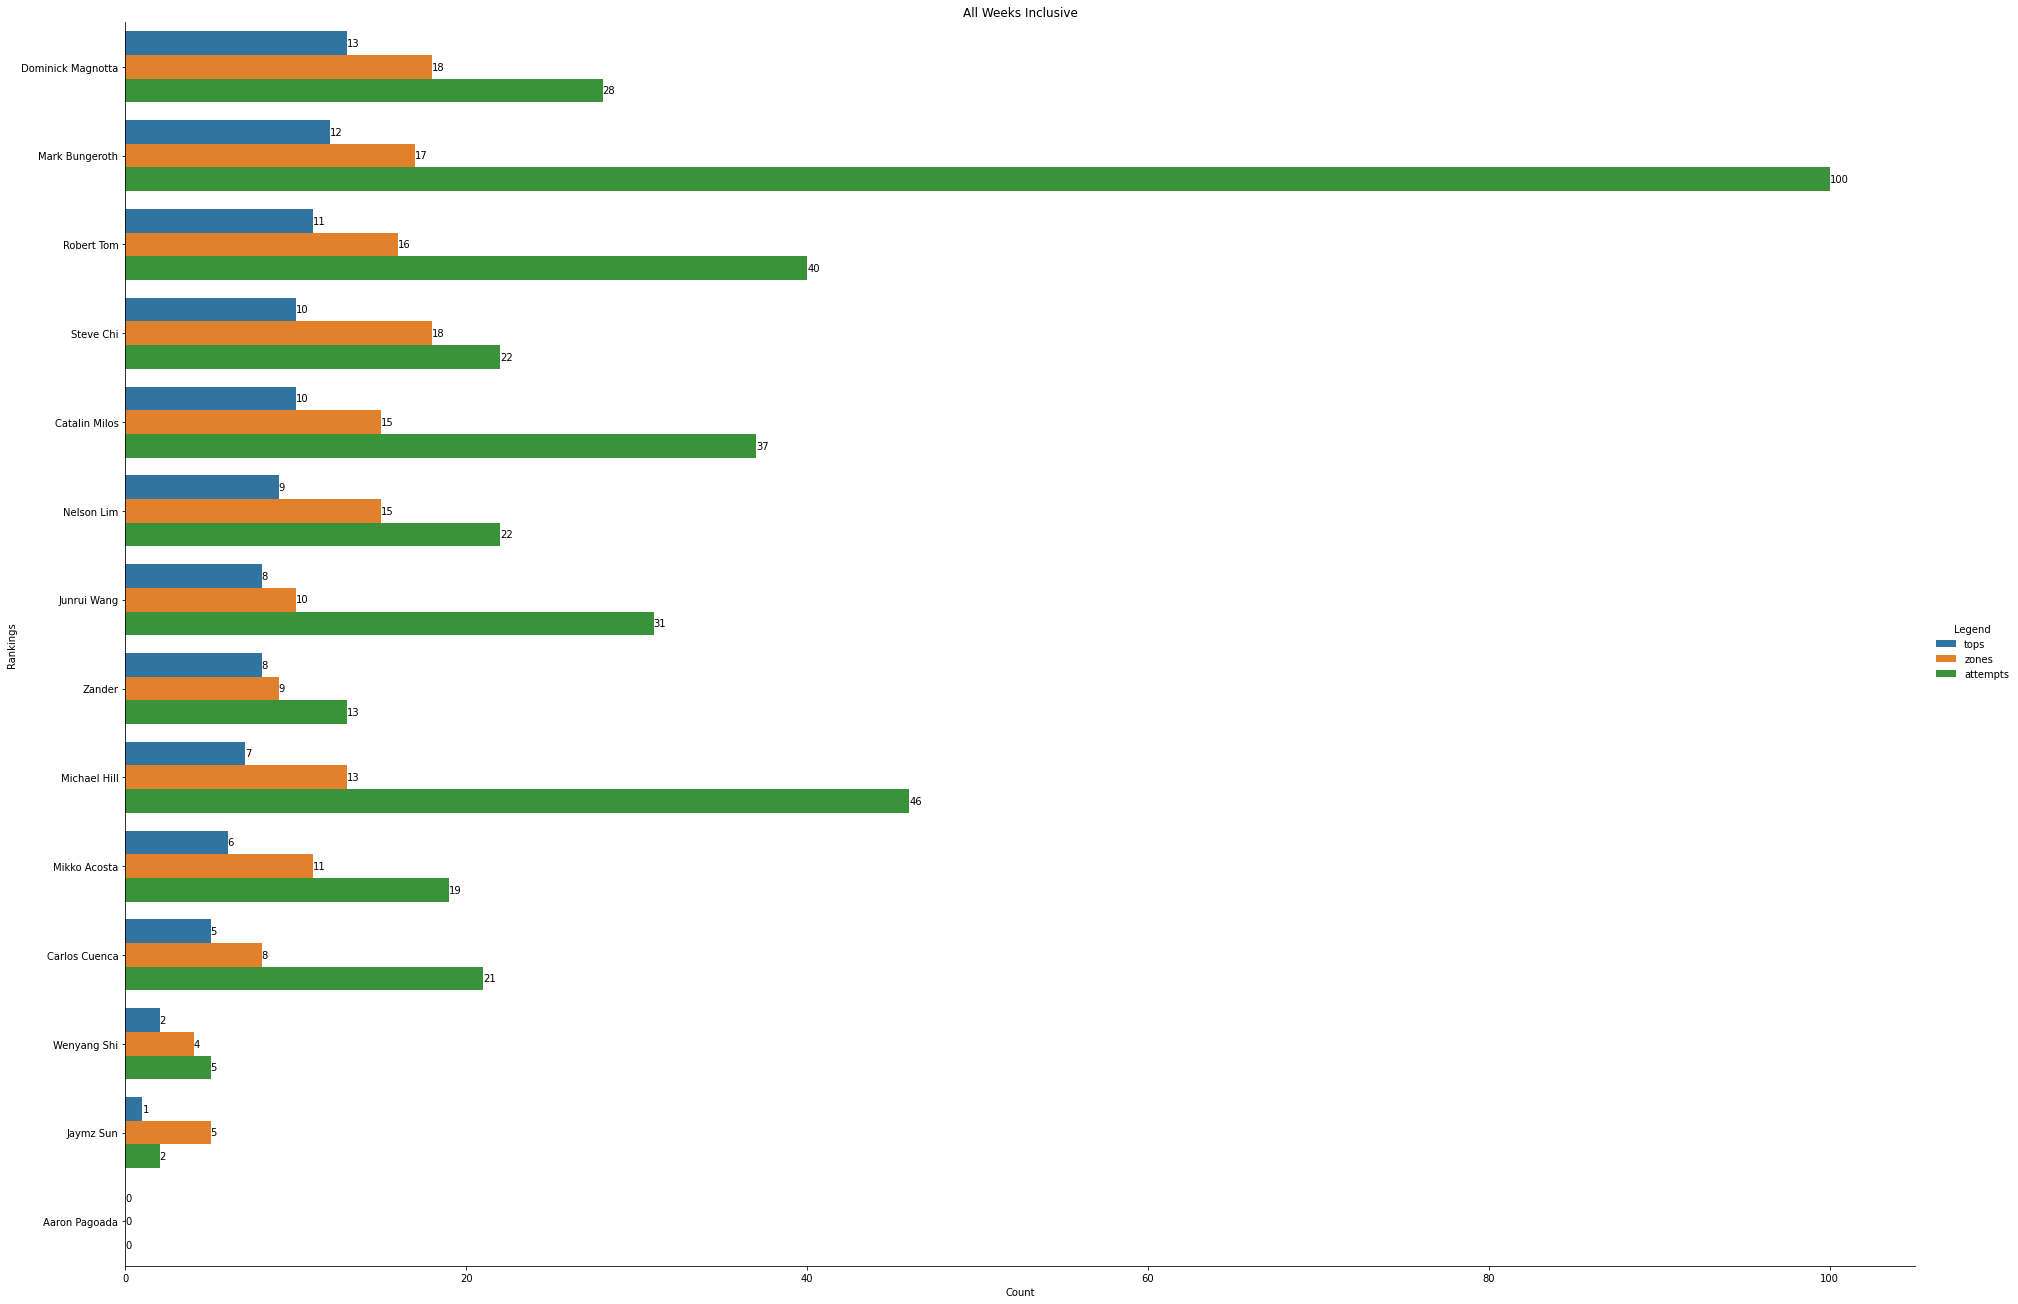

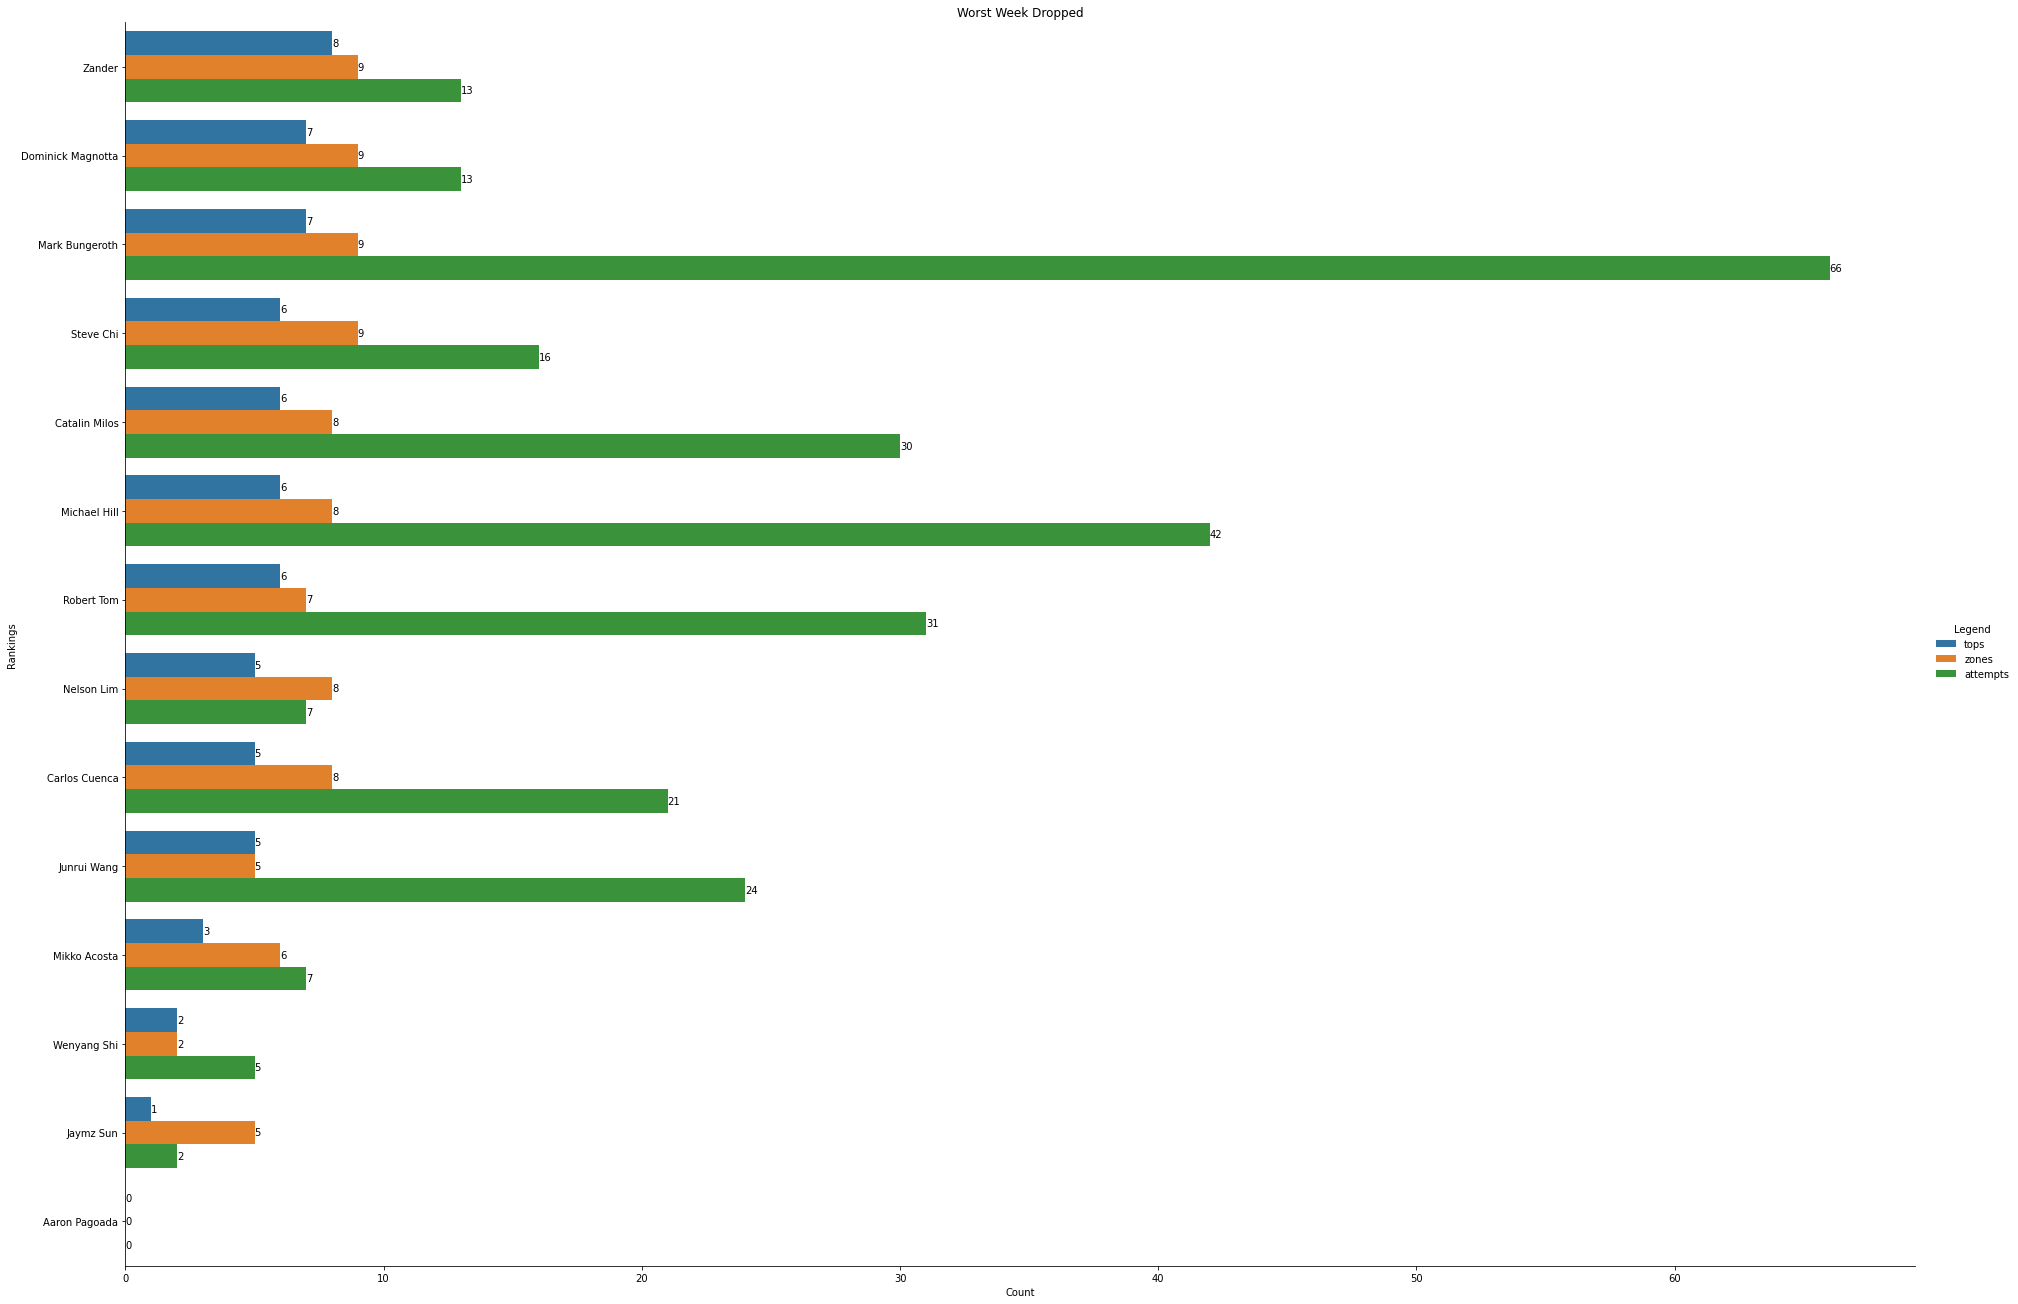

In [6]:
advanced_results_overall = prepare_results("advanced", "overall")
advanced_results_adjusted = prepare_results("advanced", "adjusted")

display(advanced_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(advanced_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

advanced_results_overall = advanced_results_overall.drop(["rank", "worst_week"], axis=1)
advanced_results_adjusted = advanced_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(advanced_results_overall, "All Weeks Inclusive")
plot_results(advanced_results_adjusted, "Worst Week Dropped")


### Intermediate Category

,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,17,19,63,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Charles Liou,2,16,19,23,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Chris Carmichael,3,16,19,34,"{""tops"": 8, ""zones"": 9, ""attempts"": 14}"
Daniel Chin,4,16,19,39,"{""tops"": 8, ""zones"": 9, ""attempts"": 15}"
John Eun,5,16,18,19,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Diego Medina,6,15,20,18,"{""tops"": 7, ""zones"": 10, ""attempts"": 8}"
Alex Abayev,7,15,19,24,"{""tops"": 6, ""zones"": 10, ""attempts"": 12}"
James Rudy,8,15,18,30,"{""tops"": 7, ""zones"": 9, ""attempts"": 14}"
Jade Chen,9,15,17,30,"{""tops"": 7, ""zones"": 8, ""attempts"": 11}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Zach Hyer,1,10,10,55,"{""tops"": 7, ""zones"": 9, ""attempts"": 8}"
Alex Abayev,2,9,9,12,"{""tops"": 6, ""zones"": 10, ""attempts"": 12}"
Diego Medina,3,8,10,10,"{""tops"": 7, ""zones"": 10, ""attempts"": 8}"
Charles Liou,4,8,10,13,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Lindsay Matheos,5,8,10,14,"{""tops"": 4, ""zones"": 9, ""attempts"": 4}"
Chris Carmichael,6,8,10,20,"{""tops"": 8, ""zones"": 9, ""attempts"": 14}"
Daniel Chin,7,8,10,24,"{""tops"": 8, ""zones"": 9, ""attempts"": 15}"
John Eun,8,8,9,9,"{""tops"": 8, ""zones"": 9, ""attempts"": 10}"
Colin Konishi,9,8,9,11,"{""tops"": 0, ""zones"": 0, ""attempts"": 0}"


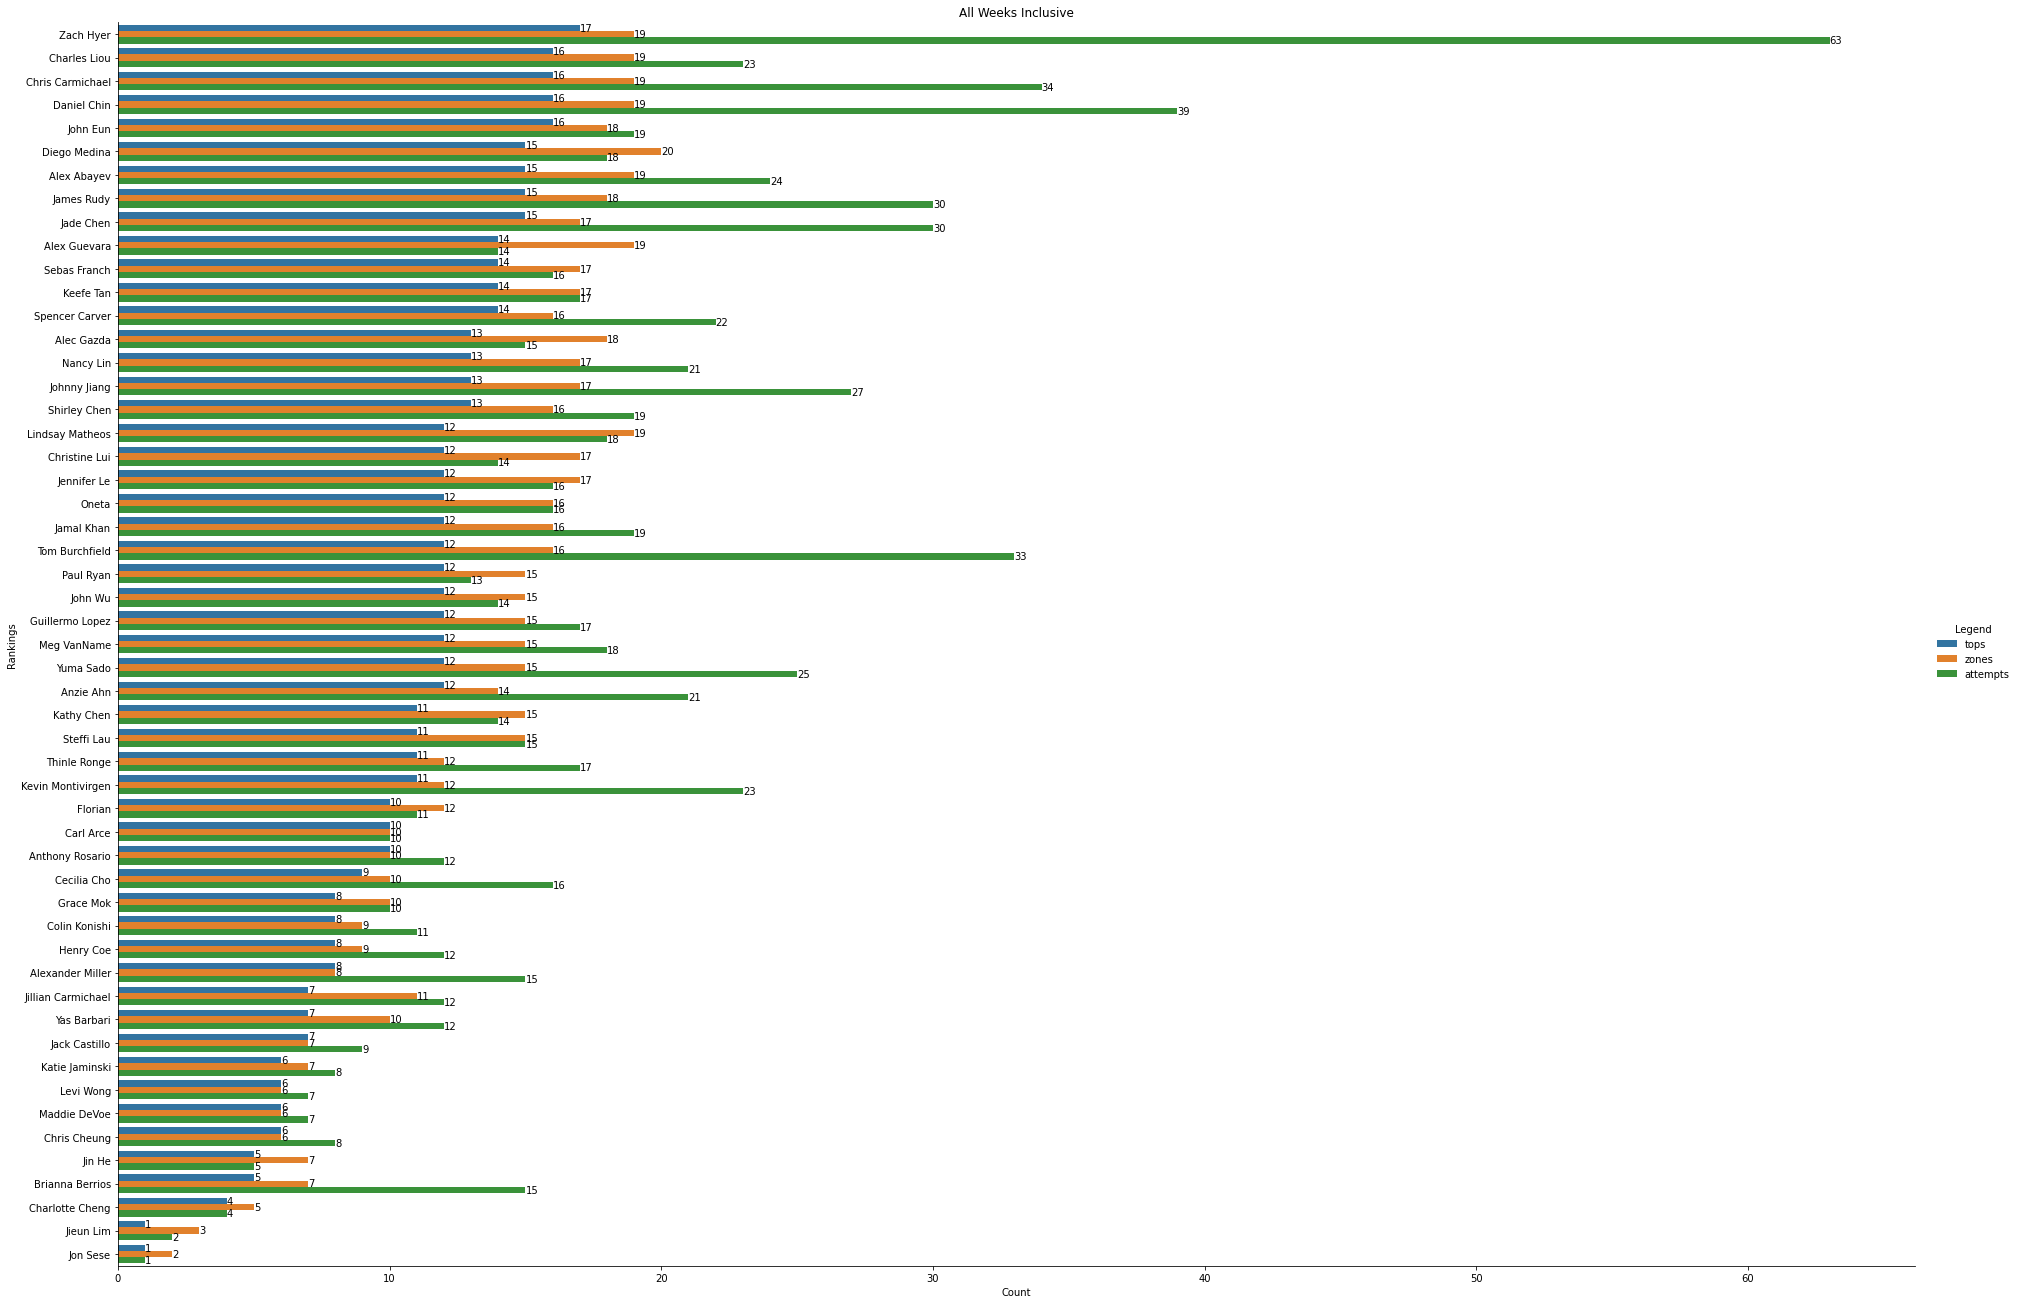

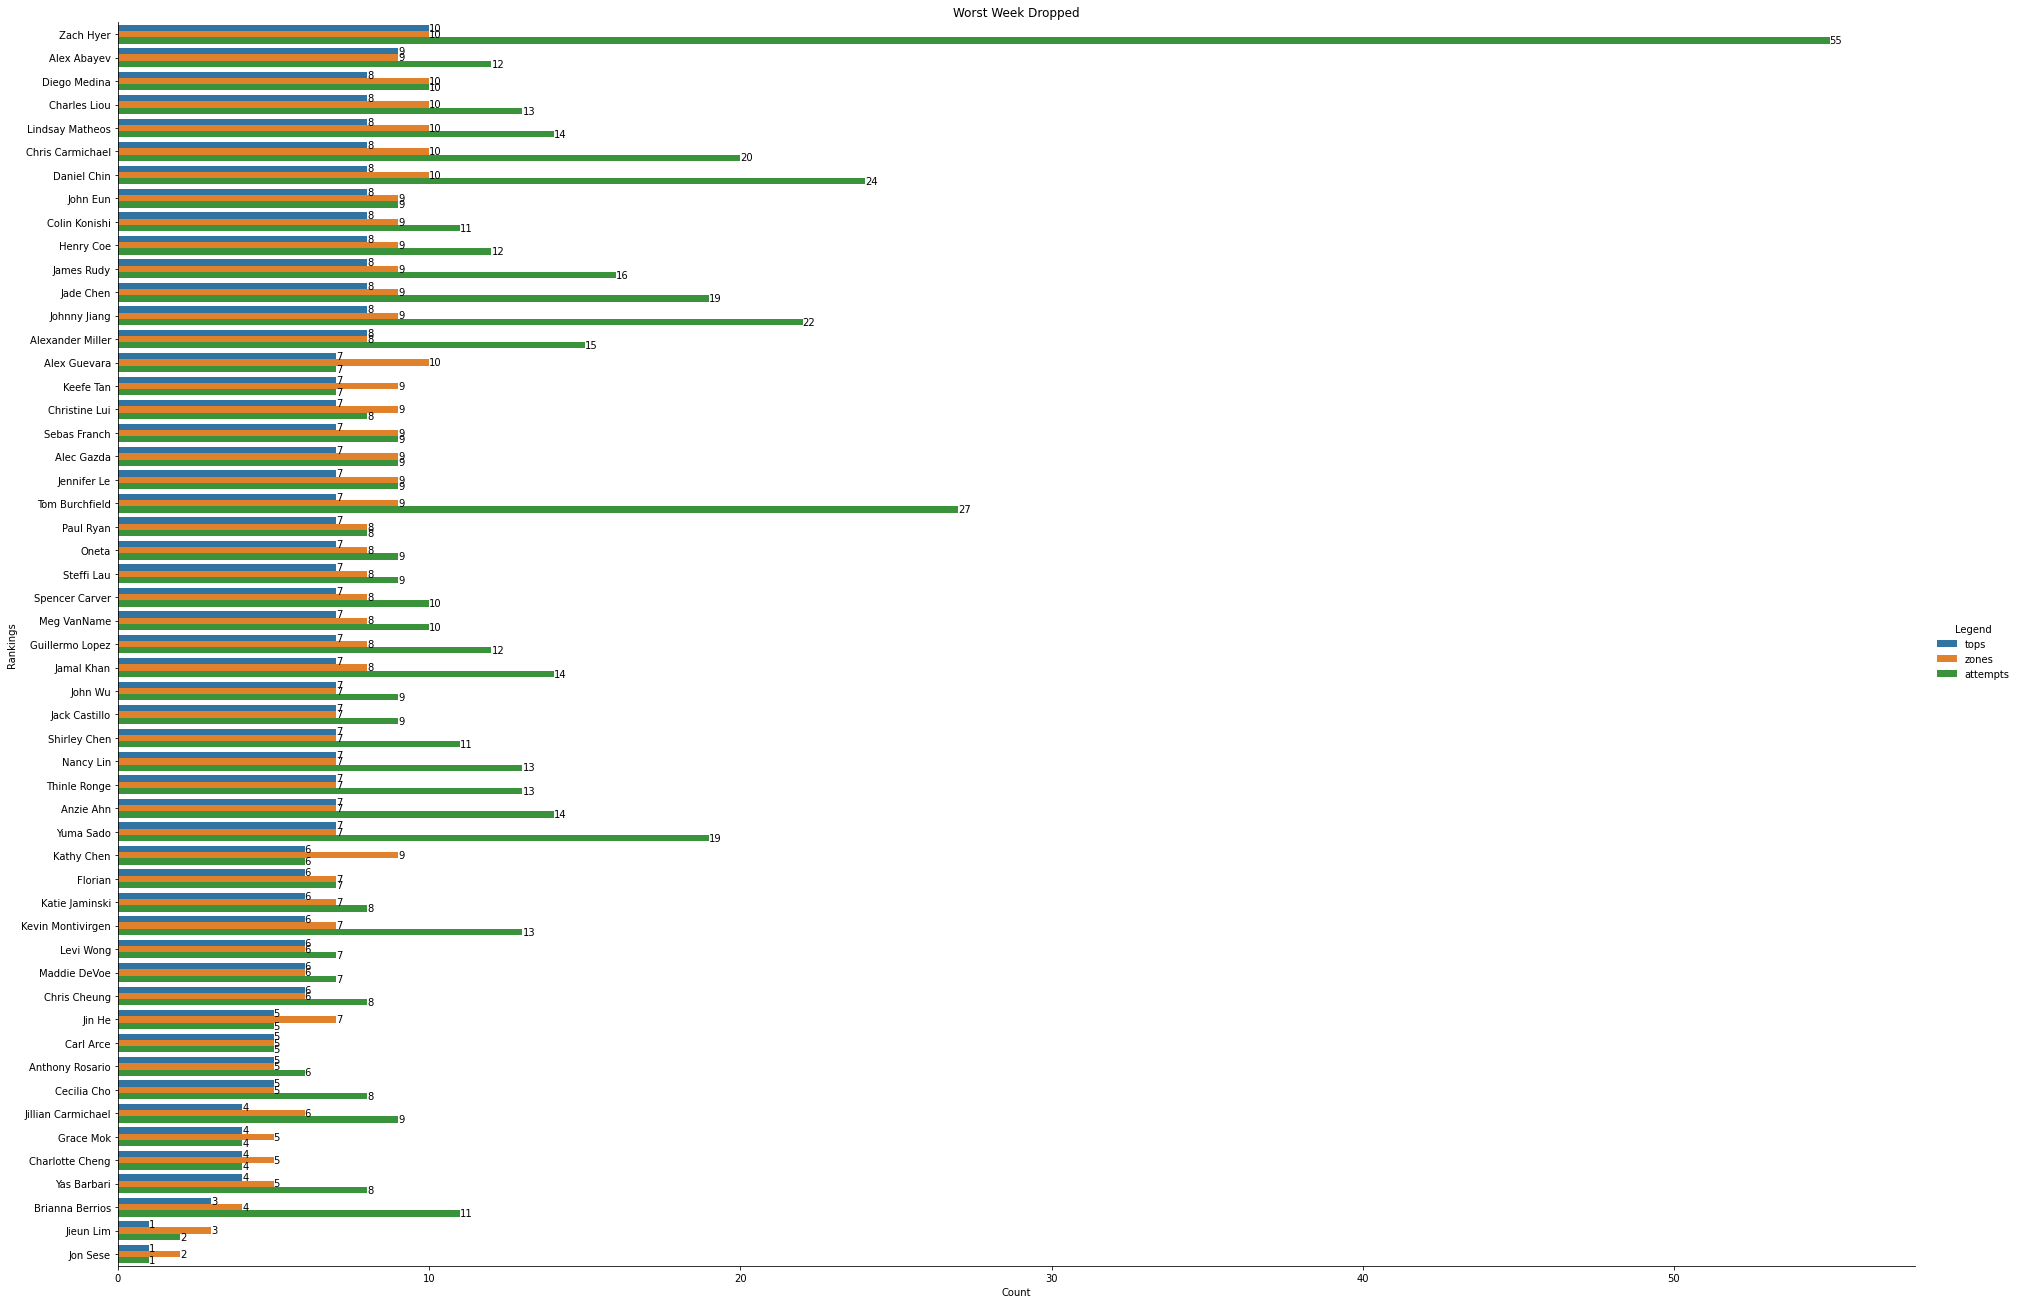

In [7]:
intermediate_results_overall = prepare_results("intermediate", "overall")
intermediate_results_adjusted = prepare_results("intermediate", "adjusted")

display(intermediate_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(intermediate_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

intermediate_results_overall = intermediate_results_overall.drop(["rank", "worst_week"], axis=1)
intermediate_results_adjusted = intermediate_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(intermediate_results_overall, "All Weeks Inclusive")
plot_results(intermediate_results_adjusted, "Worst Week Dropped")

### Recreational Category

,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,10,10,15,"{""tops"": 5, ""zones"": 5, ""attempts"": 10}"
Kate Polinsky,2,8,10,8,"{""tops"": 3, ""zones"": 5, ""attempts"": 3}"
Ava Oertle,3,7,8,7,"{""tops"": 3, ""zones"": 3, ""attempts"": 3}"
Alyssa Macaluso,4,7,8,9,"{""tops"": 3, ""zones"": 3, ""attempts"": 4}"
Armel Dogruluk,5,6,8,7,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Nicola de Prisco,6,6,8,7,"{""tops"": 3, ""zones"": 4, ""attempts"": 4}"
Amalia Aquino,7,5,9,8,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Riley Synan,8,5,7,9,"{""tops"": 2, ""zones"": 3, ""attempts"": 6}"
Sadmanul Islam,9,5,6,11,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"


,rank,tops,zones,attempts,worst_week
name,,,,,
Tyler Beckinham,1,5,5,5,"{""tops"": 5, ""zones"": 5, ""attempts"": 10}"
Kate Polinsky,2,5,5,5,"{""tops"": 3, ""zones"": 5, ""attempts"": 3}"
Ava Oertle,3,4,5,4,"{""tops"": 3, ""zones"": 3, ""attempts"": 3}"
Alyssa Macaluso,4,4,5,5,"{""tops"": 3, ""zones"": 3, ""attempts"": 4}"
Armel Dogruluk,5,4,5,5,"{""tops"": 2, ""zones"": 3, ""attempts"": 2}"
Amalia Aquino,6,3,5,6,"{""tops"": 2, ""zones"": 4, ""attempts"": 2}"
Nicola de Prisco,7,3,4,3,"{""tops"": 3, ""zones"": 4, ""attempts"": 4}"
Riley Synan,8,3,4,3,"{""tops"": 2, ""zones"": 3, ""attempts"": 6}"
Sadmanul Islam,9,3,4,5,"{""tops"": 2, ""zones"": 2, ""attempts"": 6}"


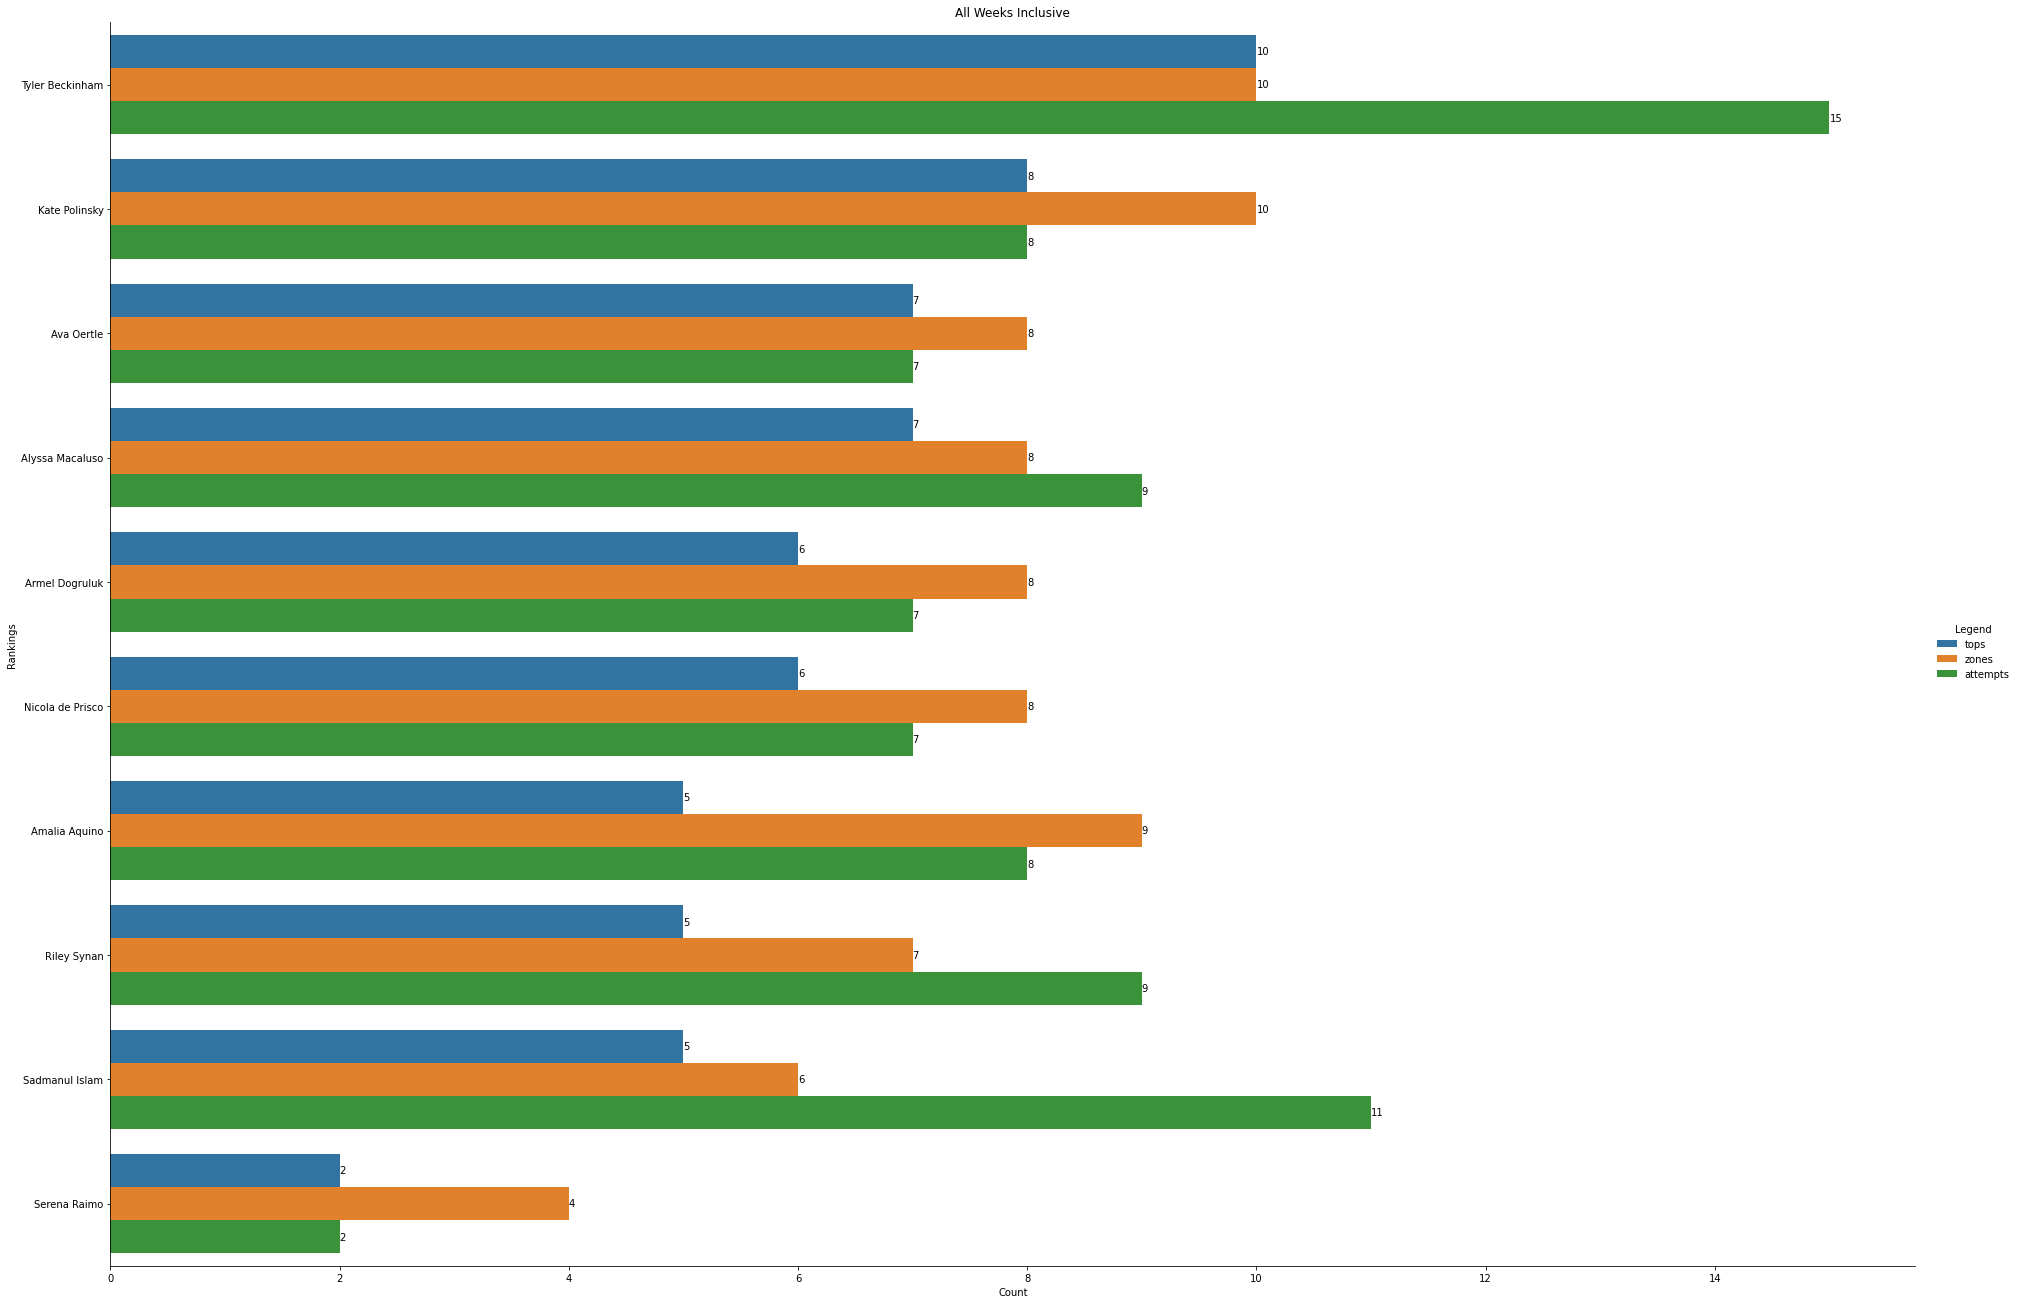

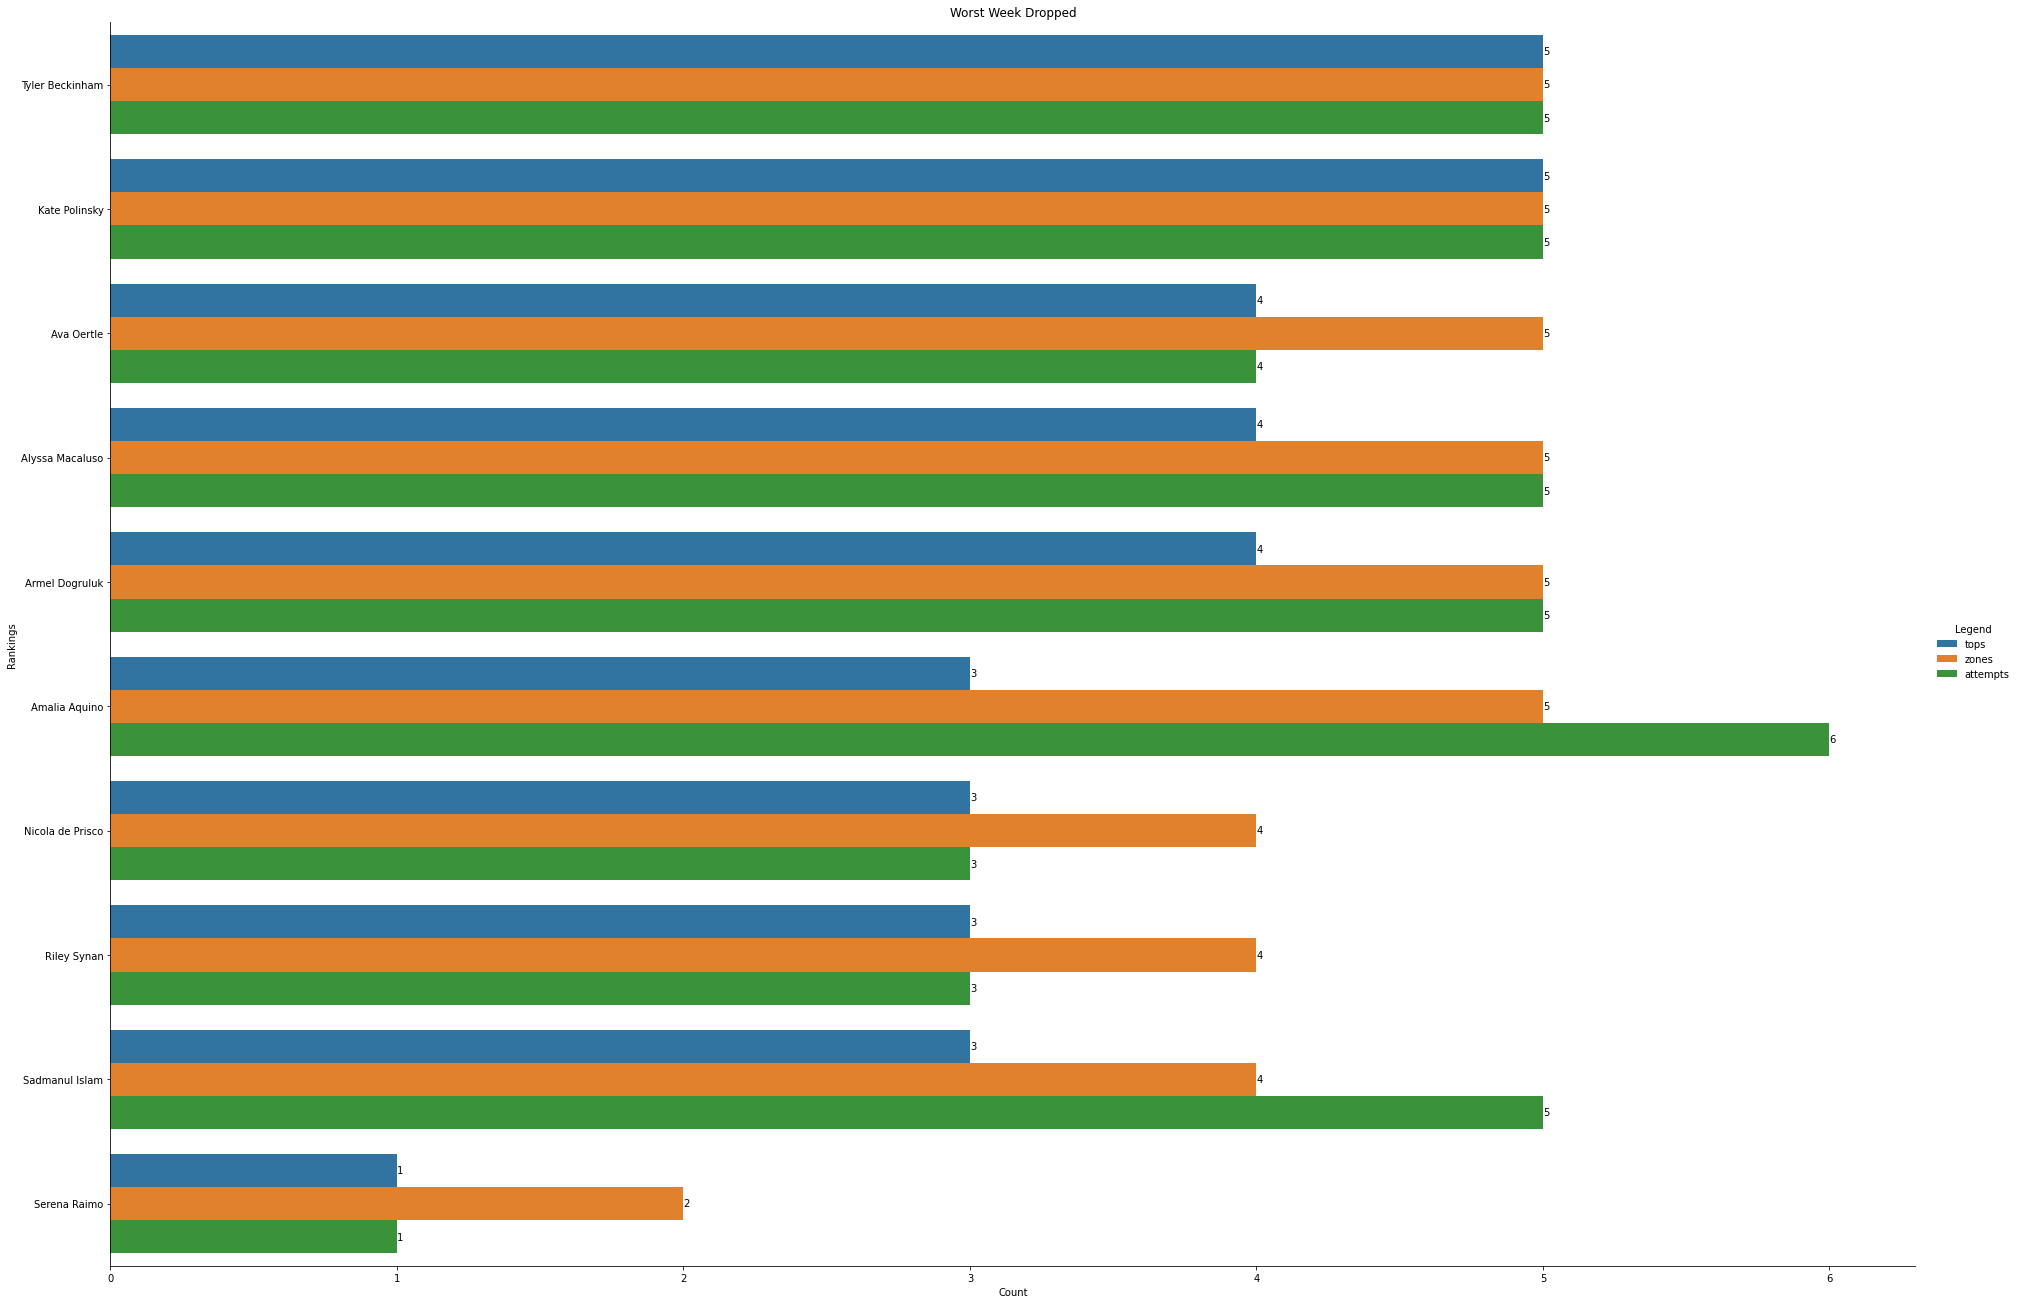

In [8]:
recreational_results_overall = prepare_results("recreational", "overall")
recreational_results_adjusted = prepare_results("recreational", "adjusted")

display(recreational_results_overall.style.set_caption('Ranking (All Weeks Inclusive)'))
display(recreational_results_adjusted.style.set_caption('Ranking (Worst Week Dropped)'))

recreational_results_overall = recreational_results_overall.drop(["rank", "worst_week"], axis=1)
recreational_results_adjusted = recreational_results_adjusted.drop(["rank", "worst_week"], axis=1)

plot_results(recreational_results_overall, "All Weeks Inclusive")
plot_results(recreational_results_adjusted, "Worst Week Dropped")

## Progression Results

### Advanced Category

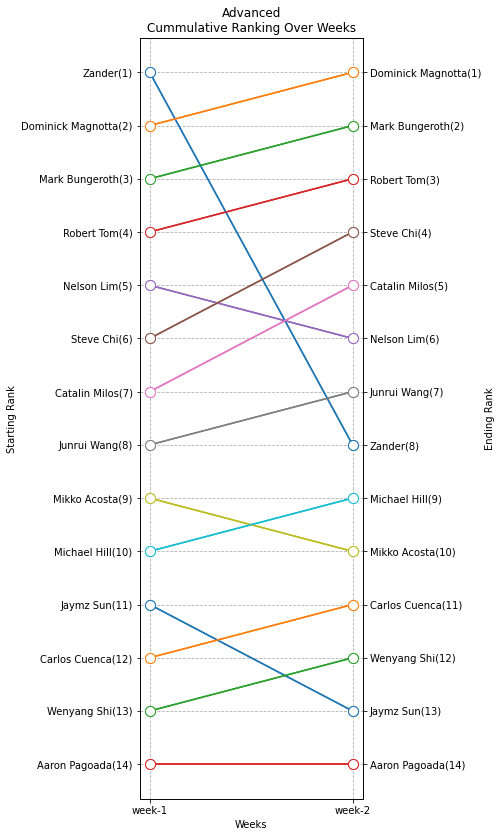

In [9]:
plot_rank_progression(weekly_ranks_cummulative("advanced"), "Advanced\nCummulative Ranking Over Weeks")

### Intermediate Category

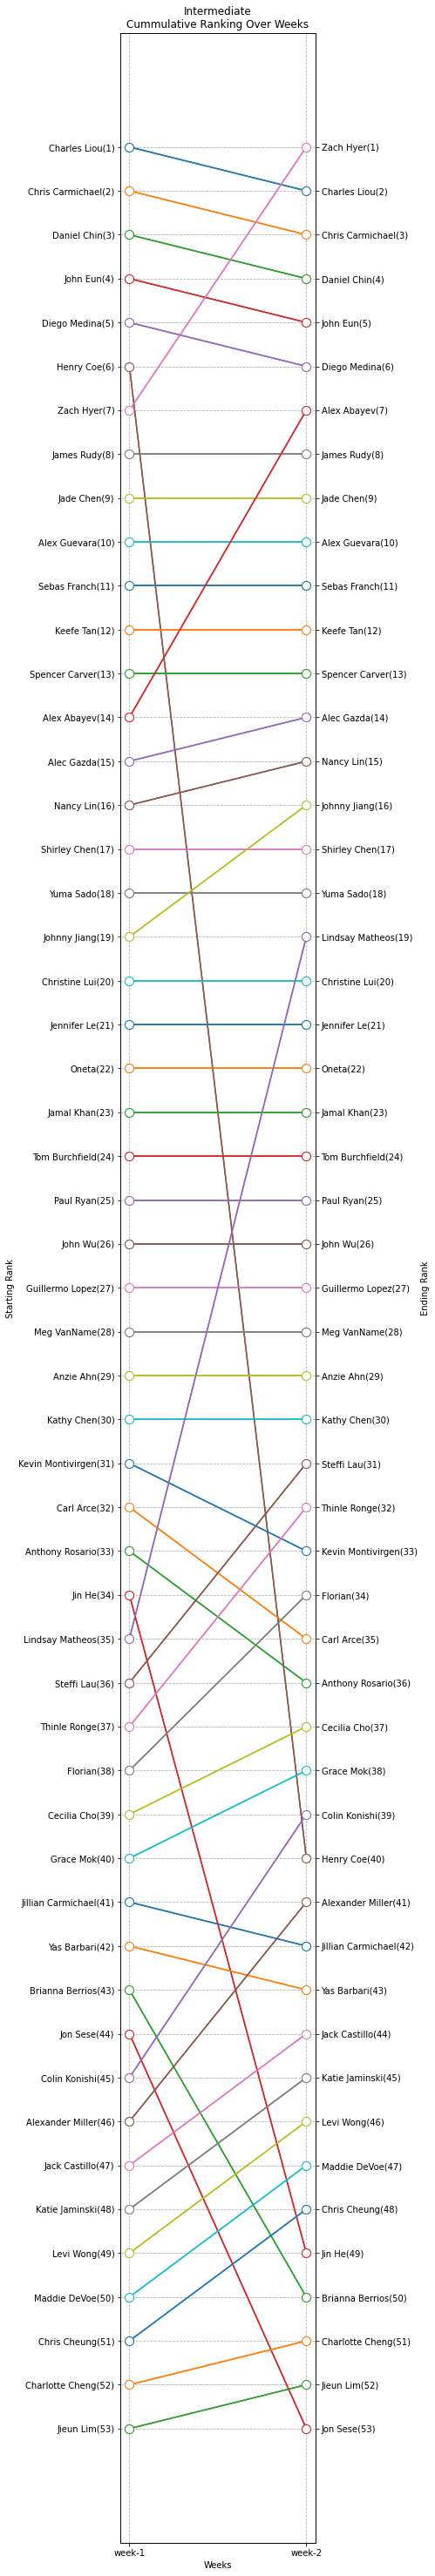

In [10]:
plot_rank_progression(weekly_ranks_cummulative("intermediate"), "Intermediate\nCummulative Ranking Over Weeks")

### Recreational Category

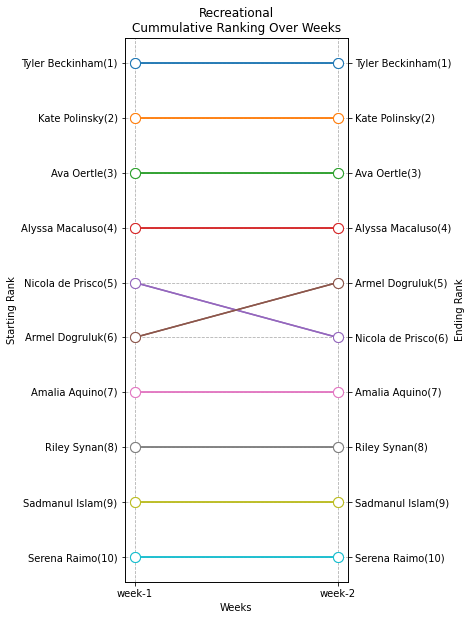

In [11]:
plot_rank_progression(weekly_ranks_cummulative("recreational"), "Recreational\nCummulative Ranking Over Weeks")

In [12]:
import json
pprint(weekly_ranks("intermediate"))

{'Alec Gazda': [16, 18],
 'Alex Abayev': [15, 2],
 'Alex Guevara': [7, 14],
 'Alexander Miller': [46, 12],
 'Anthony Rosario': [33, 43],
 'Anzie Ahn': [29, 33],
 'Brianna Berrios': [43, 49],
 'Carl Arce': [32, 42],
 'Cecilia Cho': [40, 44],
 'Charles Liou': [2, 5],
 'Charlotte Cheng': [52, 47],
 'Chris Carmichael': [3, 7],
 'Chris Cheung': [51, 41],
 'Christine Lui': [22, 16],
 'Colin Konishi': [45, 6],
 'Daniel Chin': [4, 8],
 'Diego Medina': [1, 13],
 'Florian': [38, 36],
 'Grace Mok': [39, 46],
 'Guillermo Lopez': [26, 26],
 'Henry Coe': [6, 51],
 'Jack Castillo': [47, 29],
 'Jade Chen': [13, 10],
 'Jamal Khan': [19, 27],
 'James Rudy': [9, 9],
 'Jennifer Le': [23, 19],
 'Jieun Lim': [53, 50],
 'Jillian Carmichael': [41, 45],
 'Jin He': [27, 52],
 'John Eun': [5, 4],
 'John Wu': [20, 28],
 'Johnny Jiang': [18, 11],
 'Jon Sese': [44, 53],
 'Kathy Chen': [31, 35],
 'Katie Jaminski': [48, 37],
 'Keefe Tan': [11, 15],
 'Kevin Montivirgen': [34, 38],
 'Levi Wong': [49, 39],
 'Lindsay Mat